In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from cmplotter import plot_confusion_matrix
%matplotlib inline
import numpy as np
#Set some numpy print options for displaying numpy arrays to fit maximum width of cell
np.set_printoptions(precision=8, edgeitems=30, linewidth=1000,formatter=dict(float=lambda x: "%.8g" % x))

import pandas as pd
from xgboost import XGBClassifier,plot_tree
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder,label_binarize

C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#load Dataset
data = pd.read_csv('data/2016_EGLL_Testdata_cleaned.csv', parse_dates = ['Landing_Time'], infer_datetime_format = True)
data.head()

,Landing_Time,hourofday,aircraft_registration,wind_direction_degrees,Wind_Speed_kt,Wind_And_Gust_kt,Landing_RVR_or_Vis_m,temperature_c,dew_point_c,relative_humidity,pressure_altimiter_in,RunwayTrueTrack,Landing_Visibilty_Class_RVR,present_weather_codes,Landing_RWY
0,2016-01-01 04:34:38,4,GXLEJ,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
1,2016-01-01 04:38:22,4,GSTBH,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
2,2016-01-01 04:40:38,4,GCIVH,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
3,2016-01-01 04:42:36,4,GVYUM,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R
4,2016-01-01 04:44:43,4,GBYGB,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,VMC,NaN,RW09R


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220940 entries, 0 to 220939
Data columns (total 15 columns):
Landing_Time                   220940 non-null datetime64[ns]
hourofday                      220940 non-null int64
aircraft_registration          220799 non-null object
wind_direction_degrees         203226 non-null float64
Wind_Speed_kt                  220940 non-null float64
Wind_And_Gust_kt               220940 non-null float64
Landing_RVR_or_Vis_m           220940 non-null float64
temperature_c                  220940 non-null float64
dew_point_c                    220940 non-null float64
relative_humidity              220940 non-null float64
pressure_altimiter_in          220940 non-null float64
RunwayTrueTrack                220940 non-null float64
Landing_Visibilty_Class_RVR    220940 non-null object
present_weather_codes          33015 non-null object
Landing_RWY                    220940 non-null object
dtypes: datetime64[ns](1), float64(9), int64(1), object(4)
memor

In [5]:
# One-Hot Encoding Categorical Variables pertaining to Visibility and Weather conditions which are interesting features
data = pd.get_dummies(data, columns=['Landing_Visibilty_Class_RVR', 'present_weather_codes'])
# Dropping Categorical variables which are not going to be used by the GBM model
data.drop(columns=['Landing_Time', 'aircraft_registration'],inplace = True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220940 entries, 0 to 220939
Data columns (total 65 columns):
hourofday                                   220940 non-null int64
wind_direction_degrees                      203226 non-null float64
Wind_Speed_kt                               220940 non-null float64
Wind_And_Gust_kt                            220940 non-null float64
Landing_RVR_or_Vis_m                        220940 non-null float64
temperature_c                               220940 non-null float64
dew_point_c                                 220940 non-null float64
relative_humidity                           220940 non-null float64
pressure_altimiter_in                       220940 non-null float64
RunwayTrueTrack                             220940 non-null float64
Landing_RWY                                 220940 non-null object
Landing_Visibilty_Class_RVR_CAT1            220940 non-null uint8
Landing_Visibilty_Class_RVR_CAT2            220940 non-null uint8
Landing_Visi

In [7]:
input_features = data.copy()
X_data = input_features.drop('Landing_RWY', axis=1)
y = data.Landing_RWY.values

In [8]:
X_data.head()

,hourofday,wind_direction_degrees,Wind_Speed_kt,Wind_And_Gust_kt,Landing_RVR_or_Vis_m,temperature_c,dew_point_c,relative_humidity,pressure_altimiter_in,RunwayTrueTrack,...,present_weather_codes_SHRA,present_weather_codes_SHRA HZ,present_weather_codes_SHRA VCTS,present_weather_codes_TS,present_weather_codes_TSRA,present_weather_codes_VCFG,present_weather_codes_VCSH,present_weather_codes_VCTS,present_weather_codes_VCTS -SHRA,present_weather_codes_VCTS VCSH
0,4,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,0
2,4,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,0
3,4,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,0
4,4,110.0,1.0,1.0,6000.0,2.0,1.0,93.08,30.21,89.713523,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Number of unique values Ytrn
n_classes = len(np.unique(y))
print('No. of Classes in the output:',n_classes,'and the classes are:',np.unique(y))

No. of Classes in the output: 4 and the classes are: ['RW09L' 'RW09R' 'RW27L' 'RW27R']


In [10]:
## One Hot Encode categorical variable output converting the class labels to integers
encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)
print('Encoded-Y:',encoded_y)

Encoded-Y: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 ... 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [11]:
## Convert class labels to binary representation for each of the four classes such as [0 1 0 0], [1 0 0 0], [0 0 1 0] and [0 0 0 1]
# y_bin_enc = label_binarize(y, classes=['RW09L','RW09R','RW27L','RW27R'])
# print('Output-Y:',y_bin_enc)

In [12]:
#Split the dataset into train and Test
seed = 42
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=test_size, random_state=seed)

In [13]:
# Sanity Check
print("Train dataset contains {0} rows and {1} columns".format(X_train.shape[0], X_train.shape[1]))
print("Test dataset contains {0} rows and {1} columns".format(X_test.shape[0], X_test.shape[1]))

Train dataset contains 154658 rows and 64 columns
Test dataset contains 66282 rows and 64 columns


In [14]:
print("Train possible labels: ")
print(np.unique(y_train))

print("\nTest possible labels: ")
print(np.unique(y_test))

Train possible labels: 
['RW09L' 'RW09R' 'RW27L' 'RW27R']

Test possible labels: 
['RW09L' 'RW09R' 'RW27L' 'RW27R']


In [15]:
def correct_predictions_counter(y_test,y_pred):
    '''Takes in the predictions of a model output and returns the no. of correct predictions.
    Arguments: y_test, y_pred'''
    correct = 0
    for i in range(len(y_pred)):
        if (y_test[i] == y_pred[i]):
            correct += 1
    return correct

## Training Classifier

### Using Grid Search for HyperParameter Tuning

In [16]:
# Parameters for the XGB Classifier used as estimator in the GridSearch
params_xgbclassifier = {
    'objective': 'multi:softmax',    
    'silent': 1,
    'num_class': n_classes
}

# Parameters for the Grid Search
params_gridsearch = { 
    'max_depth':[8,16],
    'n_estimators':[500,1000],
    'learning_rate': [0.01,0.0075],
    'subsample': [0.5,0.75]
}

fit_params = {'eval_metric': 'mlogloss',
              'early_stopping_rounds': 10,
              'verbose': False,
              'eval_set': [(X_test, y_test)]              
             }

# Specify Cross Validation Strategy
cv = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.3, random_state=42)

In [17]:
# Use one hot encoded output for the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=test_size, random_state=42)

# gsearch = GridSearchCV(estimator = XGBClassifier(**params), param_grid = param_test, scoring='f1_weighted',n_jobs=4,iid=False, cv=cv)
gsearch = GridSearchCV(estimator = XGBClassifier(**params_xgbclassifier), param_grid = params_gridsearch, scoring='accuracy', n_jobs=4, iid=False, cv=cv)

In [18]:
%%time
import time
print("Grid search..")
search_time_start = time.time()
train_model_gs = gsearch.fit(X_train, y_train,**fit_params)
pred_gs = train_model_gs.predict(X_test)
print("Grid Search time:", time.time() - search_time_start)

Grid search..


C:\ProgramData\Anaconda3\envs\datasciencelab\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Grid Search time: 112631.91185426712
Wall time: 1d 7h 17min 12s


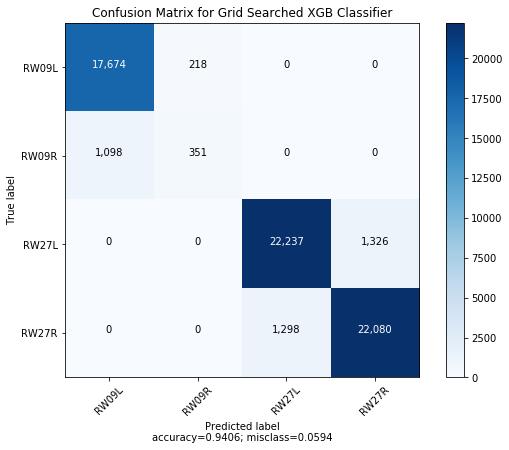

In [19]:
# Plot Confusion Matrix of classification Results
plot_confusion_matrix(cm= confusion_matrix(y_test, pred_gs), 
                      normalize    = False,
                      target_names = np.unique(y_test),
                      title        = "Confusion Matrix for Grid Searched XGB Classifier")

In [20]:
#Print the results of the grid search
print(gsearch)

GridSearchCV(cv=StratifiedShuffleSplit(labels=['RW27R' 'RW09L' ... 'RW27R' 'RW27R'], n_iter=5, test_size=0.3, random_state=42),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=4, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [8, 16], 'n_estimators': [500, 1000], 'learning_rate': [0.01, 0.0075], 'subsample': [0.5, 0.75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)


In [21]:
# Print the best score of the grid search
print('\n Best Score:',gsearch.best_score_)


 Best Score: 0.9400318979266347


In [22]:
best_score = train_model_gs.best_score_
best_params = train_model_gs.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: 0.9400318979266347
Best params: 
learning_rate: 0.0075
max_depth: 16
n_estimators: 1000
subsample: 0.5


In [23]:
# Calculate Obtained Error
print('Predicted correctly: {0}/{1}'.format(correct_predictions_counter(y_test, pred_gs), len(pred_gs)))
print("Accuracy for best grid searched model : %.2f" % (accuracy_score(y_test, pred_gs) * 100),'%')
print('Error: {0:.4f}'.format(1-(accuracy_score(y_test, pred_gs))))

Predicted correctly: 62342/66282
Accuracy for model 3: 94.06 %
Error: 0.0594


In [24]:
# summarize results
print("Best: %f using %s" % (train_model_gs.best_score_, train_model_gs.best_params_),'\n')
means = train_model_gs.cv_results_['mean_test_score']
stds = train_model_gs.cv_results_['std_test_score']
params = train_model_gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("TestScore_Mean: %f and Std_Dev: (%f) with Parameters: %r" % (mean, stdev, param))

Best: 0.940032 using {'learning_rate': 0.0075, 'max_depth': 16, 'n_estimators': 1000, 'subsample': 0.5} 

TestScore_Mean: 0.868068 and Std_Dev: (0.001662) with Parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.5}
TestScore_Mean: 0.858873 and Std_Dev: (0.000994) with Parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.75}
TestScore_Mean: 0.898203 and Std_Dev: (0.002377) with Parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.5}
TestScore_Mean: 0.890344 and Std_Dev: (0.002291) with Parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 1000, 'subsample': 0.75}
TestScore_Mean: 0.939691 and Std_Dev: (0.000972) with Parameters: {'learning_rate': 0.01, 'max_depth': 16, 'n_estimators': 500, 'subsample': 0.5}
TestScore_Mean: 0.939847 and Std_Dev: (0.000951) with Parameters: {'learning_rate': 0.01, 'max_depth': 16, 'n_estimators': 500, 'subsample': 0.75}
TestScore_Mean: 0

### Notes:
- Specifying `num_class` parameter for multiclass grid search seems to be [optional](https://stackoverflow.com/questions/39386966/multiclass-classification-in-xgboost-python) as there is no difference in accuracy score.
- In grid-search using `scoring = f1` gives error as it is meant for binary classification. Need to use appropriate [scoring metric](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) such as `f1_weighted` for multi-class classification.
- Using `scoring = f1_samples` with non encoded raw **y** gives error as f-score is not meaningful outside multilabel classification. we have to use numerically encoded y for each class (eg: 1,2,3,4 ). `f1_weighted` and `accuracy` can handle raw *y* .

### Resources:
- https://www.kaggle.com/dkim1992/grid-search-vs-random-search